In [22]:
import ee

ee.Initialize()

def image_scaler(img):
    optical = img.select("SR_B.+").multiply(2.75e-5).add(-0.2)
    thermal = img.select("ST_B.+").multiply(0.00341802).add(149)

    img = img.addBands(optical, None, True).addBands(thermal, None, True)

    return img

def cloud_mask(img):
    qa = img.select("QA_PIXEL")
    
    cirrus = qa.bitwiseAnd((1 << 2)).eq(0)
    cloud = qa.bitwiseAnd((1 << 3)).eq(0)
    shadow = qa.bitwiseAnd((1 << 4)).eq(0)
    snow = qa.bitwiseAnd((1 << 5)).eq(0)
    
    img = (
        img.updateMask(cirrus)
           .updateMask(cloud)
           .updateMask(shadow)
           .updateMask(snow)
    )

    return img

def renamer7(img):
    ori_names = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "ST_B6"]
    new_names = ["BLUE", "GREEN", "RED", "NIR", "TEMPERATURE"]
    
    img = img.select(ori_names).rename(new_names)

    return img

def renamer8(img):
    ori_names = ["SR_B2", "SR_B3", "SR_B4", "SR_B5", "ST_B10"]
    new_names = ["BLUE", "GREEN", "RED", "NIR", "TEMPERATURE"]
    
    img = img.select(ori_names).rename(new_names)

    return img

def calc_ndvi(img):
    f = "(b('NIR')-b('RED'))/(b('NIR')+b('RED'))"
    ndvi = img.expression(f).rename("NDVI")

    img = img.addBands(ndvi)

    return img

In [23]:
forests = ee.FeatureCollection("projects/ee-sebnarvaez-mangroves/assets/forests")
roi = forests.filter(ee.Filter.eq("key", "mallorquin"))

roi.first().getInfo()["properties"]

{'area': 3013573.18211,
 'area [ha]': 301.357,
 'dpto': 'Atlántico',
 'key': 'mallorquin',
 'scale': '1:25000',
 'swamp': 'Mallorquín Swamp',
 'year': 2017}

In [24]:
L8 = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
      .filterBounds(roi.first().geometry())
      .filter(ee.Filter.eq("PROCESSING_LEVEL", "L2SP"))
)

L8 = L8.map(image_scaler).map(cloud_mask).map(renamer8).map(calc_ndvi)

L8.size().getInfo()

416

In [25]:
L8.first().getInfo()["bands"]

[{'id': 'BLUE',
  'data_type': {'type': 'PixelType',
   'precision': 'double',
   'min': -0.2,
   'max': 1.6022125},
  'dimensions': [7331, 7311],
  'crs': 'EPSG:32618',
  'crs_transform': [30, 0, 435285, 0, -30, 1388115]},
 {'id': 'GREEN',
  'data_type': {'type': 'PixelType',
   'precision': 'double',
   'min': -0.2,
   'max': 1.6022125},
  'dimensions': [7331, 7311],
  'crs': 'EPSG:32618',
  'crs_transform': [30, 0, 435285, 0, -30, 1388115]},
 {'id': 'RED',
  'data_type': {'type': 'PixelType',
   'precision': 'double',
   'min': -0.2,
   'max': 1.6022125},
  'dimensions': [7331, 7311],
  'crs': 'EPSG:32618',
  'crs_transform': [30, 0, 435285, 0, -30, 1388115]},
 {'id': 'NIR',
  'data_type': {'type': 'PixelType',
   'precision': 'double',
   'min': -0.2,
   'max': 1.6022125},
  'dimensions': [7331, 7311],
  'crs': 'EPSG:32618',
  'crs_transform': [30, 0, 435285, 0, -30, 1388115]},
 {'id': 'TEMPERATURE',
  'data_type': {'type': 'PixelType',
   'precision': 'double',
   'min': 149,
   '

In [26]:
import geemap

from geemap import cartoee

In [29]:
vis = {"bands": ["RED", "GREEN", "BLUE"], "min": 0.0, "max": 0.3, "gamma": 1.3}

Map = geemap.Map()

Map.addLayer(L8.sort("CLOUD_COVER_LAND").first(), vis, "TC (432)")
Map.addLayer(roi, opacity=0.1, name="ROI")

Map.centerObject(roi)

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [30]:
roi.first().geometry().bounds().coordinates().getInfo()

[[[-74.91404810273207, 11.028868816913656],
  [-74.82934525005177, 11.028868816913656],
  [-74.82934525005177, 11.062596879860857],
  [-74.91404810273207, 11.062596879860857],
  [-74.91404810273207, 11.028868816913656]]]

In [32]:
forests.filter(ee.Filter.eq("key", "virgen")).first().geometry().bounds().coordinates().getInfo()

[[[-75.51173334636263, 10.409937971541012],
  [-75.4639732791029, 10.409937971541012],
  [-75.4639732791029, 10.512366397279758],
  [-75.51173334636263, 10.512366397279758],
  [-75.51173334636263, 10.409937971541012]]]

In [33]:
zr_mallorquin = [-74.82934525005177, 11.028868816913656, -74.91404810273207, 11.062596879860857]
zr_totumo = [-75.21347135428282, 10.690516171754405, -75.25896861605656, 10.760405796055716]
zr_virgen = [-75.4639732791029, 10.409937971541012, -75.51173334636263, 10.512366397279758]

'2017-12-18'

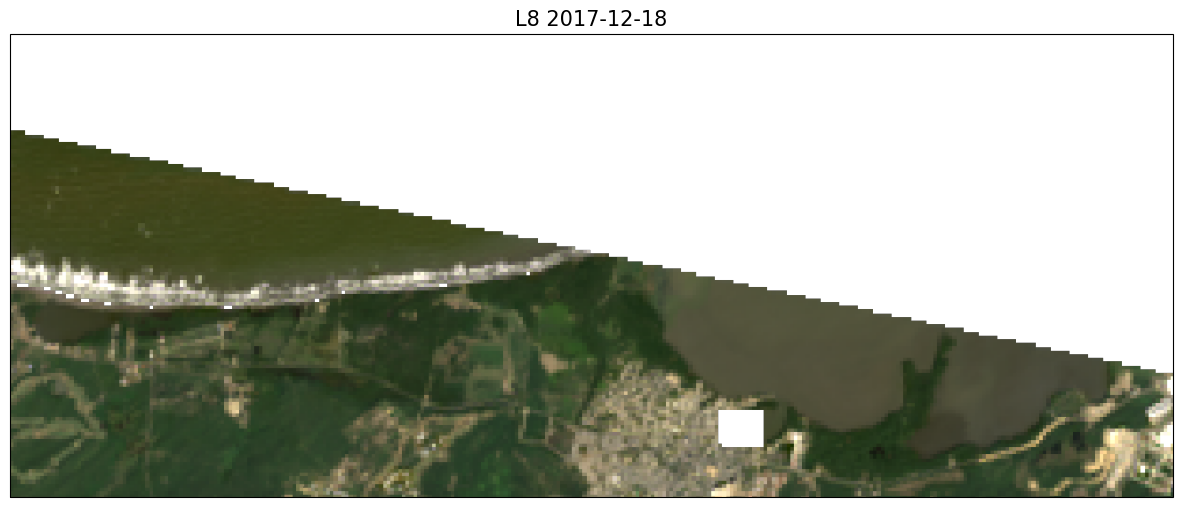

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))

ax = cartoee.get_map(L8.sort("CLOUD_COVER_LAND").first(), vis_params=vis, region=zr_mallorquin)

# ax.coastlines(color="yellow")
d = L8.sort("CLOUD_COVER_LAND").first().getInfo()["properties"]["DATE_ACQUIRED"]

ax.set_title(f"L8 {d}", fontsize=15)

plt.show()

In [49]:
L5 = (
    ee.ImageCollection("LANDSAT/LT05/C02/T1_L2").map(image_scaler)
                                                .map(cloud_mask)
                                                .map(renamer7)
                                                .map(calc_ndvi)
                                                .filter(ee.Filter.calendarRange(1996, 1998, "year"))
)

L7 = (
    ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").map(image_scaler)
                                                .map(cloud_mask)
                                                .map(renamer7)
                                                .map(calc_ndvi)
                                                .filter(ee.Filter.calendarRange(1999, 2013, "year"))
)

L8 = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").map(image_scaler)
                                                .map(cloud_mask)
                                                .map(renamer8)
                                                .map(calc_ndvi)
                                                .filter(ee.Filter.calendarRange(2014, 2021, "year"))
)

IC = L5.merge(L7.merge(L8))

In [52]:
ICF = IC.filterBounds(roi)
N = ICF.size().getInfo()

In [53]:
N

564

In [55]:
dates = (
        ICF.reduceColumns(ee.Reducer.toList(), ["DATE_ACQUIRED"])
        .get("list")
        .getInfo()
    )

len(dates)

564